In [553]:
import cv2
#print(cv2.__version__)
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [554]:
device = "cpu" # please change it to "gpu" if the model needs to be run on cuda.

In [555]:
from os.path import dirname, join
protoFile = '/Users/zhousq/Documents/Part_1/pose/coco/pose_deploy_linevec.prototxt'
weightsFile = '/Users/zhousq/Documents/Part_1/pose/coco/pose_iter_440000.caffemodel'
#protoFile = join('/Users/zhousq/Documents/pose/coco',"pose_deploy_linevec.prototxt")
#weightsFile = join('/Users/zhousq/Documents/pose/coco',"pose_iter_440000.caffemodel")
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]


In [556]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
#Strategies:
#try to change threshold number
#try to change kernel size in gaussianblue
#try a different filter rather than gaussian blur
#_, threshold = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

def getKeypoints(probMap, threshold=0.1): #0.1
#threshold 0.1
#kernel size 3*3
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0) #(3,3),0,0
    #mapSmooth = cv2.blur(probMap, ksize = (7, 7))
    #mapSmooth = cv2.medianBlur(probMap, 7)
    #mapSmooth = cv2.bilateralFilter(probMap, 7, sigmaSpace = 75, sigmaColor =75)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


## Use the following equation for finding valid joint-pairs

![](./pose-estimation-paf-equation.png)

In the above equation:

L is the PAF;

d is the vector joining two joints;

p is the interpolated point between two joints;

It is implemented using the dot product between the PAF and the vector $d_{ij}$

In [557]:
# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10 #10
    paf_score_th = 0.216 #0.1
    conf_th = 0.55 #0.7
    
    #conf_th, conf_th is the threshold for PAF, filtering the valid pair
    #PAF: Thus, the direction and location of the whole limbs, instead of just their joints, are natural things to consider in a body-tracking network.
    #To represent such information, we introduce partial affinity fields (PAF).
    #https://arvrjourney.com/implementation-of-paf-openpose-pose-detection-network-its-training-accelerations-on-gcp-2d0dd561e0c0
    
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs


In [558]:
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [559]:
image1 = cv2.imread("images/image3.jpg")
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]
#_, threshold = cv2.threshold(image1, 127, 255, cv2.THRESH_BINARY)

#### Load the network and pass the image through the network

In [560]:
t = time.time()
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, scalefactor= 1 / 255, size =(inWidth, inHeight), #1.0 /255
                          mean = (1, 22, 17), swapRB=False, crop=True) #(0,0,0)
#mean = (1, 22, 17)
##inpBlob = cv2.dnn.blobFromImage(image, scalefactor =1.0,size,mean,swapRB=True, crop=False,ddepth = CV_32F)
#https://www.codenong.com/cs106070631/

net.setInput(inpBlob)
output = net.forward()
print("Time Taken = {}".format(time.time() - t))

Using CPU device
Time Taken = 1.0724570751190186


#### Slice a probability map ( for e.g Nose ) from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

(-0.5, 1199.5, 1799.5, -0.5)

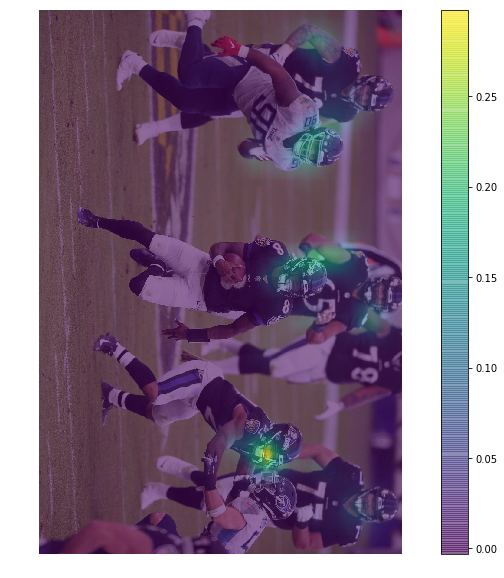

In [561]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [562]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1 #0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)


Keypoints - Nose : [(754, 1467, 0.29749715), (1102, 1036, 0.13249767), (909, 840, 0.18341807), (872, 450, 0.16897617), (909, 98, 0.15037556)]
Keypoints - Neck : [(717, 1428, 0.41803935), (908, 880, 0.48963645), (870, 410, 0.23399913), (947, 176, 0.36457172)]
Keypoints - R-Sho : [(832, 1623, 0.18362428), (986, 1546, 0.13909332), (716, 1388, 0.56227183), (870, 840, 0.42906743), (948, 411, 0.10114621), (908, 333, 0.10261185), (871, 138, 0.39548835)]
Keypoints - R-Elb : [(870, 1781, 0.26196107), (910, 1467, 0.34988794), (677, 1310, 0.56146622), (1141, 1037, 0.12708402), (600, 801, 0.62559956), (909, 762, 0.5643326), (677, 449, 0.21368995), (792, 177, 0.5074991)]
Keypoints - R-Wr : [(909, 1467, 0.42613611), (638, 1388, 0.63232803), (599, 840, 0.86733085), (909, 764, 0.34263095), (716, 451, 0.22855765), (676, 136, 0.23668256), (832, 97, 0.30868596)]
Keypoints - L-Sho : [(1025, 1663, 0.11964999), (948, 1546, 0.10599786), (716, 1545, 0.47524518), (1025, 997, 0.42224458), (792, 451, 0.20305438)

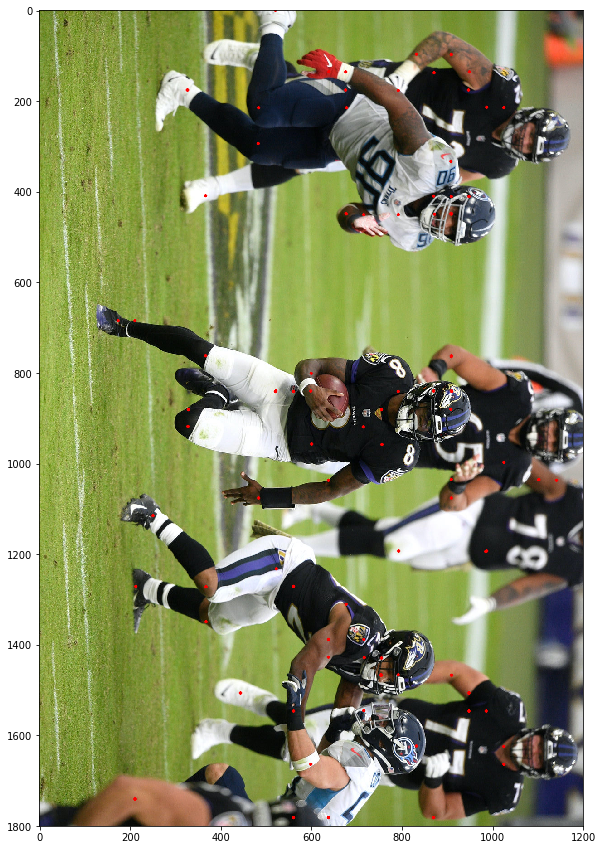

In [563]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [564]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[  5.        ,  11.        ,   0.48399542],
       [  6.        ,  12.        ,   0.27434249],
       [  8.        ,  15.        ,   0.28391393]]), array([[  5.       ,  33.       ,   0.2694123],
       [  8.       ,  36.       ,   0.2368582]]), array([[ 10.        ,  17.        ,   0.35686132],
       [ 11.        ,  18.        ,   0.52555586],
       [ 12.        ,  20.        ,   0.57875828],
       [ 15.        ,  23.        ,   0.28923547]]), array([[ 17.        ,  24.        ,   0.36767262],
       [ 18.        ,  25.        ,   0.36033402],
       [ 20.        ,  26.        ,   0.72439616],
       [ 21.        ,  27.        ,   0.25638864]]), array([[ 33.        ,  38.        ,   0.36379598],
       [ 34.        ,  39.        ,   0.56194826]]), array([[ 38.        ,  45.        ,   0.76964472],
       [ 39.        ,  48.        ,   0.63989217],
       [ 40.        ,  47.        ,   0.56259919],
       [ 43.        ,  51.        ,   0.56860141]]), array([[  5.        ,  5

In [565]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

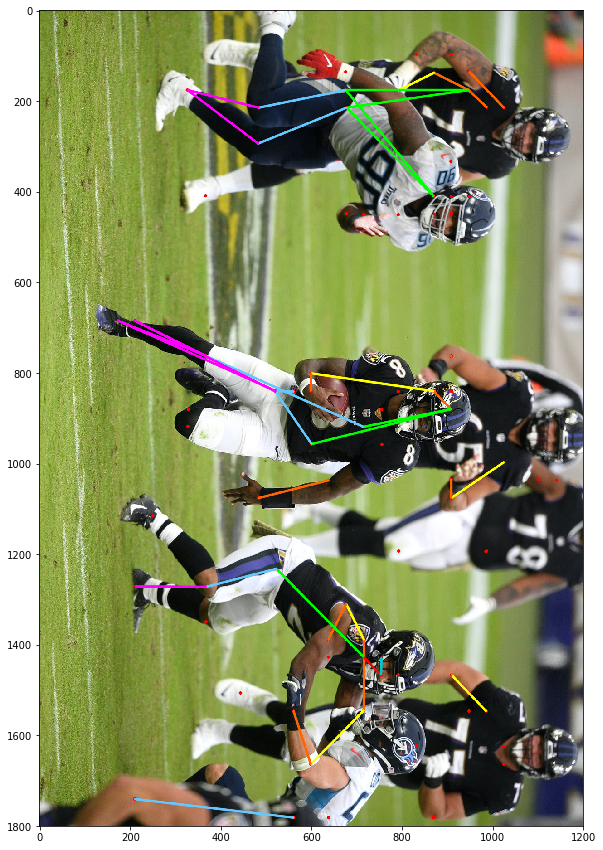

In [566]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [567]:
"""
Question - Run the openpose on the images provided in pat-1 folder and try to reason about 
why it’s not working for some of the images and what’s the way to fix it?

Problem: in image 3,
1. there is not enough body part locations predicted in confidence map(the first printed graph)
2. the color from the background and the objects(helmet, pants) lying in the boundary of two different people
3. the arm looking like another person's leg

Explanations:
In side of getValidPairs function:
conf_th is a threshold.
If conf_th is too small, then one person's join mismatches with the body join from another person.
If conf_th is too large, then the joins and limbs from one person disappear.(tested in image2, indeed)

PAF(paf_score_th in getValidPairs function) has effect on the body part locations in confidence map.
(Usually, the direction and the location of the whole limbs, instead of just the joins)
If the value of PAF is too small, the joins are mismatched(one person's join mismatches the join from another person)
If the value of PAF is too large, there is less or no limbs detected. 
Once the PAF is predicted, one can use it to help limb matching given multiple people in the same picture.


Inside of the function below:
inpBlob = cv2.dnn.blobFromImage(image1, scalefactor= 30 / 255, (inWidth, inHeight), #1.0 /255
                          mean=(0, 20, 0), swapRB=False, crop=False) #(0,0,0)
                          
                          
If the scalefactor is too large,
then there will be less body part locations predicted in confidence map(the first image printed), which is not good for our result.
For example scalefactor = 30 /255 is too large in our cases. 


Mean is the value we subtract from the RGB value of the original image.
This is super helpful to handle the job with colorful background.
For example, in our image3, there is bunch of green grass as the background, which disturbs with the pose dectection.
Then we give a reasonable value to Green color in mean, say mean = (0,20,0); which reduces the green color in the image.
Also, there is too much dark color in image3. Especially, the dark color is similar of one's helmet and other person's pants,
which makes the boundary unclear.
Thus, I tuned the mean value into mean = (0,20,17).
Hence, the performance of our experiment improves.

Be careful, when you subtract too much RGB from the original image, there will be no joins detected. 



Beside this,
I have also tried different blurring strategies, such as Gaussian blurring, median blurring, bilateral filtering.
These strategies play less important roles in this homework assignment.

Last but not the least:
Threshold, it helps on the join and limbs detection.
When threshold is large, it helps on distinguishing each individual person.
When threshold is small, it helps on detecting more joins. 



Settings: 
(Strategies: tune paf_score_th and conf_th, the mean and maintance the threshold)
For image 3,

    paf_score_th = 0.16 #0.1
    conf_th = 0.55 #0.7
    
inpBlob = cv2.dnn.blobFromImage(image1, scalefactor= 1 / 255, size =(inWidth, inHeight),
                          mean = (1, 22, 17), swapRB=False, crop=True) 
                          
For image 1 and image 2,
I think the original setting is fine.

"""


"\nQuestion - Run the openpose on the images provided in pat-1 folder and try to reason about \nwhy it’s not working for some of the images and what’s the way to fix it?\n\nProblem: in image 3,\n1. there is not enough body part locations predicted in confidence map(the first printed graph)\n2. the color from the background and the objects(helmet, pants) lying in the boundary of two different people\n3. the arm looking like another person's leg\n\nExplanations:\nIn side of getValidPairs function:\nconf_th is a threshold.\nIf conf_th is too small, then one person's join mismatches with the body join from another person.\nIf conf_th is too large, then the joins and limbs from one person disappear.(tested in image2, indeed)\n\nPAF(paf_score_th in getValidPairs function) has effect on the body part locations in confidence map.\n(Usually, the direction and the location of the whole limbs, instead of just the joins)\nIf the value of PAF is too small, the joins are mismatched(one person's join